Use this code to generate synthetic data for Lutein production. The inputs of the data-driven model would be concentration of biomass (C_X) in the reactor, concentration of nitrate (C_N) in the reactor, concentration of Lutein (C_L) in the reactor, influx of nitrate (F_in), inlet nitrate concentration (C_N_in), light intensity (I0), and time t hours. The output should be C_X, C_N, and C_L at t+1 hours. 

In [1]:
# Following are parameters of the model mostly taken from https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.15667 but changed slightly (after unit conversion)
# Do not change this... 

u_m = 0.152 # 1/h
u_d = 5.95*1e-3 # 1/h
K_N = 30.0*1e-3 # g/L

Y_NX = 0.305 # g/g

k_m = 0.350*1e-3*2 #g/g-h

k_d = 3.71*0.05/90 # L/g-h

K_NL = 10.0*1e-3 # g/L

k_s = 142.8 # umol/m2-s

k_i = 214.2 # umol/m2-s

k_sL = 320.6 # umol/m2-s

k_iL = 480.9 # umol/m2-s

tau = 0.120 #m2/g

Ka = 0.0 #1/m

## Combinations using Itertools

In [2]:
import itertools
import numpy as np

#To generate data, just change these values in this block (perhaps in a loop), In my opinion, 
#a good range for C_x0 (which is the initial concnentration of biomass in the reactor C_X) is 0.2 - 2 g/L
# a good range for C_N0 (which is the initial concnetraiton of nitrate in the reactor C_N) is 0.2 - 2 g/L
# a good range for F_in (the inlet flow rate of nitrate into the reactor) is 1e-3 1.5e-2 L/h
# a good range for C_N_in (the inlet concentration of nitrate feed to the reactor) is 5 - 15 g/L
# a good range for intensity of light is 100 - 200 umol/m2-s

num_values = 5
#Create array of test values for each variable
C_x0_r = np.linspace(0.2, 2, num_values) #g/L
C_N0_r = np.linspace(0.2, 2, num_values) #g/L
F_in_r = np.linspace(1e-3, 1.5e-2, num_values) #L/h
C_N_in_r = np.linspace(5, 15, num_values) #g/L
I0_r = np.linspace(100, 200, num_values) # umol/m2-s

synth_data = []

synth_data = list(itertools.product(C_x0_r, C_N0_r, F_in_r, C_N_in_r, I0_r))

# Print the combinations
for combination in synth_data:
    print(combination)

(0.2, 0.2, 0.001, 5.0, 100.0)
(0.2, 0.2, 0.001, 5.0, 125.0)
(0.2, 0.2, 0.001, 5.0, 150.0)
(0.2, 0.2, 0.001, 5.0, 175.0)
(0.2, 0.2, 0.001, 5.0, 200.0)
(0.2, 0.2, 0.001, 7.5, 100.0)
(0.2, 0.2, 0.001, 7.5, 125.0)
(0.2, 0.2, 0.001, 7.5, 150.0)
(0.2, 0.2, 0.001, 7.5, 175.0)
(0.2, 0.2, 0.001, 7.5, 200.0)
(0.2, 0.2, 0.001, 10.0, 100.0)
(0.2, 0.2, 0.001, 10.0, 125.0)
(0.2, 0.2, 0.001, 10.0, 150.0)
(0.2, 0.2, 0.001, 10.0, 175.0)
(0.2, 0.2, 0.001, 10.0, 200.0)
(0.2, 0.2, 0.001, 12.5, 100.0)
(0.2, 0.2, 0.001, 12.5, 125.0)
(0.2, 0.2, 0.001, 12.5, 150.0)
(0.2, 0.2, 0.001, 12.5, 175.0)
(0.2, 0.2, 0.001, 12.5, 200.0)
(0.2, 0.2, 0.001, 15.0, 100.0)
(0.2, 0.2, 0.001, 15.0, 125.0)
(0.2, 0.2, 0.001, 15.0, 150.0)
(0.2, 0.2, 0.001, 15.0, 175.0)
(0.2, 0.2, 0.001, 15.0, 200.0)
(0.2, 0.2, 0.0045, 5.0, 100.0)
(0.2, 0.2, 0.0045, 5.0, 125.0)
(0.2, 0.2, 0.0045, 5.0, 150.0)
(0.2, 0.2, 0.0045, 5.0, 175.0)
(0.2, 0.2, 0.0045, 5.0, 200.0)
(0.2, 0.2, 0.0045, 7.5, 100.0)
(0.2, 0.2, 0.0045, 7.5, 125.0)
(0.2, 0.2, 0.0045,

In [3]:
len(synth_data)

3125

The code below formulates and solves the ODE model in the paper https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.15667

We specifically use equations 1, 2, and 3. We approximate 3 for some intermediate value of Z to avoid using the averaging shown in equation 4. 

In [4]:
def pbr(t,C): # returns the RHS of the ODE model
    C_X = C[0] # concentration of biomass
    C_N = C[1] # concentration of nitrate
    C_L = C[2] # concentration of lutein
    
    I = 2*I0*(np.exp(-(tau*0.01*1000*C_X))) # computing attenuated intensity within the reactor. 
    
    Iscaling_u = I/(I+k_s + I**2/k_i)
    Iscaling_k = I/(I + k_sL + I**2/k_iL)
    
    u0 = u_m*Iscaling_u
    k0 = k_m*Iscaling_k
    
        
    #print(u_m, k_m, u0, k0,u_d)
    

    
    dCxdt = u0*C_N*C_X/(C_N + K_N) - u_d*C_X
    
    #print(C_N, C_X, (C_N + K_N), dCxdt, C_N*C_X/(C_N + K_N), u_d*C_X, C_N/(C_N + K_N))
    
    dCndt = -Y_NX*u0*C_N*C_X/(C_N + K_N) + F_in * C_N_in
    
    dCldt = k0*C_N*C_X/(C_N + K_NL) - k_d*C_L*C_X
    
    #print(k0, k_d, k0/k_d )
    
    return np.array([dCxdt, dCndt, dCldt])

In [5]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

mainData = pd.DataFrame()
for i, data in enumerate(synth_data):
    C_x0, C_N0, F_in, C_N_in, I0 = data
    
    ta = np.linspace(0,150,200)
    
   
    y = solve_ivp(pbr, [0, 150], np.array([C_x0, C_N0, 0.0]), t_eval=ta) # solves the ODE model for a given set of initial conditions and simulation time
    

    t = y.t
    C = y.y
    #print(C[2]*1000)
    save = pd.DataFrame()
    save['Time'] = t
    save['C_X'] = C[0]
    save['C_N'] = C[1]
    save['C_L'] = C[2]
    save['C_x0'] = C_x0
    save['C_N0'] = C_N0
    save['F_in'] = F_in
    save['C_N_in'] = C_N_in
    save['I0'] = I0
    save['Index'] = i
    mainData = pd.concat([mainData, save])

#from pathlib import Path  

#filepath = Path('Documents\STEMVisualsSynthData_Opt.csv')  

#filepath.parent.mkdir(parents=True, exist_ok=True)  

#mainData.to_csv(filepath) 

In [6]:
mainData

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
0,0.000000,0.200000,0.200000,0.000000,0.2,0.2,0.001,5.0,100.0,0
1,0.753769,0.206758,0.201430,0.000030,0.2,0.2,0.001,5.0,100.0,0
2,1.507538,0.213746,0.202779,0.000062,0.2,0.2,0.001,5.0,100.0,0
3,2.261307,0.220972,0.204047,0.000094,0.2,0.2,0.001,5.0,100.0,0
4,3.015075,0.228439,0.205231,0.000127,0.2,0.2,0.001,5.0,100.0,0
...,...,...,...,...,...,...,...,...,...,...
195,146.984925,3.490712,33.772813,0.005313,2.0,2.0,0.015,15.0,200.0,3124
196,147.738693,3.491313,33.937453,0.005319,2.0,2.0,0.015,15.0,200.0,3124
197,148.492462,3.491903,34.102095,0.005324,2.0,2.0,0.015,15.0,200.0,3124
198,149.246231,3.492482,34.266739,0.005329,2.0,2.0,0.015,15.0,200.0,3124


In [7]:
endpoint_df = mainData[mainData["Time"] == 150]

In [8]:
endpoint_df

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
199,150.0,2.006485,0.027028,0.007875,0.2,0.2,0.001,5.0,100.0,0
199,150.0,2.013439,0.019712,0.008746,0.2,0.2,0.001,5.0,125.0,1
199,150.0,2.019022,0.015707,0.009490,0.2,0.2,0.001,5.0,150.0,2
199,150.0,2.024251,0.013200,0.010139,0.2,0.2,0.001,5.0,175.0,3
199,150.0,2.029450,0.011501,0.010717,0.2,0.2,0.001,5.0,200.0,4
...,...,...,...,...,...,...,...,...,...,...
199,150.0,2.906175,34.747109,0.004491,2.0,2.0,0.015,15.0,100.0,3120
199,150.0,3.094429,34.647194,0.004783,2.0,2.0,0.015,15.0,125.0,3121
199,150.0,3.248642,34.564268,0.005006,2.0,2.0,0.015,15.0,150.0,3122
199,150.0,3.379576,34.493308,0.005186,2.0,2.0,0.015,15.0,175.0,3123


In [9]:
max_L_row = endpoint_df.iloc[endpoint_df['C_L'].idxmax()]

In [10]:
max_L_row

Time      150.000000
C_X         3.416535
C_N        17.049822
C_L         0.008309
C_x0        0.200000
C_N0        0.650000
F_in        0.008000
C_N_in     15.000000
I0        200.000000
Index     199.000000
Name: 199, dtype: float64

In [11]:
type(max_L_row)

pandas.core.series.Series

In [12]:
#Variables
opt_index = max_L_row['Index']
opt_index

199.0

## Plot Optimized

In [14]:
optData = mainData.loc[mainData["Index"] == opt_index]

In [15]:
optData

,Time,C_X,C_N,C_L,C_x0,C_N0,F_in,C_N_in,I0,Index
0,0.000000,0.200000,0.650000,0.000000,0.2,0.65,0.008,15.0,200.0,199
1,0.753769,0.206739,0.738119,0.000040,0.2,0.65,0.008,15.0,200.0,199
2,1.507538,0.213766,0.826140,0.000080,0.2,0.65,0.008,15.0,200.0,199
3,2.261307,0.221088,0.914062,0.000123,0.2,0.65,0.008,15.0,200.0,199
4,3.015075,0.228714,1.001881,0.000166,0.2,0.65,0.008,15.0,200.0,199
...,...,...,...,...,...,...,...,...,...,...
195,146.984925,3.408260,16.709208,0.008339,0.2,0.65,0.008,15.0,200.0,199
196,147.738693,3.410389,16.794348,0.008332,0.2,0.65,0.008,15.0,200.0,199
197,148.492462,3.412477,16.879497,0.008324,0.2,0.65,0.008,15.0,200.0,199
198,149.246231,3.414525,16.964655,0.008317,0.2,0.65,0.008,15.0,200.0,199


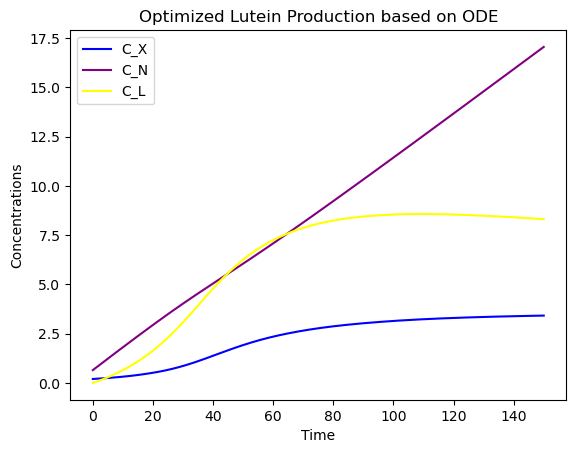

In [23]:
import matplotlib.pyplot as plt

plt.plot(optData['Time'], optData['C_X'], label = "C_X", color = 'blue')
plt.plot(optData['Time'], optData['C_N'], label = "C_N", color = 'purple')
plt.plot(optData['Time'], (optData['C_L'] * 1000), label = "C_L", color = 'yellow')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.title("Optimized Lutein Production based on ODE")
plt.show()

0.008309
0.007762